# Project: Interpret Decision Tree for Sentiment Classification Using Important Features

## Objectives
The goal of this mini-project deliverable is to extract important features from a model and combine them with decision tree visualizations to:
1. Identify which features, among the large number of features (hundreds), are most important for the model.
2. Interpret the role important features play in the model. For example:
   - Does the presence (or absence) of a word in a tweet make it more likely to indicate positive sentiment?
3. Compare important features generated across different folds in a k-fold cross-validation. This enables:
   - Identification of multiple sets of important features.
   - Generation of additional questions about the relationship between these features and the sentiment class (e.g., positive/negative) you aim to predict from a tweet.

## Acknowledgement
The `datascience` module used in this project is developed by the University of California, Berkeley, for its Data 8 course.

## Why Is Extracting Important Features from a Model Important?
- Helps users understand the patterns and knowledge the model has learned from the data.
- Builds trust in the model by providing insight into how it operates.
- Comparing feature importance across cross-validation folds can reveal the reliability of feature importance.

## How Scikit-learn Helps Identify Important Features
- Scikit-learn's decision tree learning provides `feature_importances_`, an array associating:
  - Feature names with their importance measures.
- The importance measures of all features sum up to 1.


In [ ]:
import datascience
import numpy as np
import graphviz

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.base import ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

from graphviz import *

import pandas as pd
import numpy as np

import joblib

#import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Mount Google Drive

We need to first mount the Google Drive in Colab before we can read data from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/DS200Labs/IMDBReviewsSentiment.csv"
reviews = Table.read_table(path)
reviews.show(10)

review,sentiment
One of the other reviewers has mentioned that after watc ...,positive
A wonderful little production. The filming t ...,positive
I thought this was a wonderful way to spend time on a to ...,positive
Basically there's a family where a little boy (Jake) thi ...,negative
"Petter Mattei's ""Love in the Time of Money"" is a visuall ...",positive
"Probably my all-time favorite movie, a story of selfless ...",positive
I sure would like to see a resurrection of a up dated Se ...,positive
"This show was an amazing, fresh & innovative idea in the ...",negative
Encouraged by the positive comments about this film on h ...,negative
If you like original gut wrenching laughter you will lik ...,positive


## Sample 1000 positive reviews

In [ ]:
pos_reviews = reviews.where("sentiment", are.equal_to('positive')).sample(1000, with_replacement=False)
pos_reviews.show(10)

review,sentiment
"Carl Brashear (Cuba Gooding, Jr.) was born to sharecropp ...",positive
"In Where The Sidewalk Ends, Otto Preminger reunites Dana ...",positive
As this movie unfolds you start to feel the conundrum of ...,positive
"To view the fictionalized biography ""The Phenix City Sto ...",positive
"When I first saw this show, I thought it looked interest ...",positive
This movie is well done. It really attempts to show what ...,positive
Robot jox is a great little film ok some of ...,positive
It'll soon be 10 yrs since this movie was released....st ...,positive
"Multiply named and strangely casted, ""One Dark Night"" ak ...",positive
"Although the plot of this film is a bit far-fetched, it ...",positive


In [ ]:
pos_reviews2 = pos_reviews.with_column("classification", 1)
pos_reviews2.show(5)

review,sentiment,classification
"Carl Brashear (Cuba Gooding, Jr.) was born to sharecropp ...",positive,1
"In Where The Sidewalk Ends, Otto Preminger reunites Dana ...",positive,1
As this movie unfolds you start to feel the conundrum of ...,positive,1
"To view the fictionalized biography ""The Phenix City Sto ...",positive,1
"When I first saw this show, I thought it looked interest ...",positive,1


## Sample 1000 negative reviews

In [ ]:
neg_reviews = reviews.where("sentiment", are.equal_to('negative')).sample(1000, with_replacement=False)
neg_reviews.show(10)

review,sentiment
The 33 percent of the nations nitwits that still support ...,negative
"Admittedly, you can put a model airplane against a black ...",negative
"When i come on IMDb boards,I'm always fed up when i see ...",negative
Saw this late one night on cable. At the time I didn't k ...,negative
"No spoiler needed to steer you clear of this...well, biz ...",negative
"I'll give credit where credit is due, and say that Linda ...",negative
"THE DEADLY MANTIS certainly won't scare any one, but as ...",negative
"Dreamgirls, despite its fistful of Tony wins in an incre ...",negative
"I saw this film at the Rotterdam Festival, as did presum ...",negative
Prom Night 2 is an OK horror movie but prom night is way ...,negative


In [ ]:
neg_reviews2 = neg_reviews.with_column("classification", 0)
neg_reviews2.show(5)

review,sentiment,classification
The 33 percent of the nations nitwits that still support ...,negative,0
"Admittedly, you can put a model airplane against a black ...",negative,0
"When i come on IMDb boards,I'm always fed up when i see ...",negative,0
Saw this late one night on cable. At the time I didn't k ...,negative,0
"No spoiler needed to steer you clear of this...well, biz ...",negative,0


In [ ]:
reviews2 = pos_reviews2.append(neg_reviews2)
reviews2.show(5)
data = reviews2

review,sentiment,classification
"Carl Brashear (Cuba Gooding, Jr.) was born to sharecropp ...",positive,1
"In Where The Sidewalk Ends, Otto Preminger reunites Dana ...",positive,1
As this movie unfolds you start to feel the conundrum of ...,positive,1
"To view the fictionalized biography ""The Phenix City Sto ...",positive,1
"When I first saw this show, I thought it looked interest ...",positive,1


# Code: Extract Text and Classifications from Reviews and Count Sentiments

The following code will:
1. Extract the text of reviews into the variable `data_X`.
2. Extract the classification of reviews into the variable `data_Y`.
3. Calculate the number of positive and negative reviews.

In [ ]:
# Use the data for constructing a Decision Tree Classifier for Review Sentiment
data_X = list(data['review'])
data_Y = list(data['classification'])
pos_count = data.where('classification', are.equal_to(1)).num_rows
neg_count = data.where('classification', are.equal_to(0)).num_rows

print('Data size:', len(data_X))
print('Positive Data Size: ', pos_count)
print('Negative Data Size: ', neg_count)

Data size: 2000
Positive Data Size:  1000
Negative Data Size:  1000


# Identifying Important Features for the Model with Best Max_depth

1. Use the `max_depth` value chosen from Project Deliverable #1 to construct decision trees.
2. Assess the importance of features for the decision tree model.

## Why Assess Feature Importance with Cross Validation?

- If feature importance is assessed using only one decision tree, the results may not be reliable.  
- By leveraging Stratified KFold Cross Validation, we can construct multiple assessments (one for each fold) to identify reliably important features.  
- This approach provides a broader perspective on the consistency and reliability of feature importance across different training-testing splits.

## Tasks for Project Deliverable #2

1. **Construct Decision Trees**: Use the optimal `max_depth` from Deliverable #1 and apply it to train decision trees for each fold in a Stratified KFold Cross Validation.  
2. **Assess Feature Importance**: For each fold, extract and store the feature importance from the decision tree model.  
3. **Analyze Consistency**: Compare feature importance across the folds to identify consistently important features.  

### Steps

1. **Load Data**:
   - Use the cleaned and preprocessed data from Deliverable #1.
   
2. **Set Up Stratified KFold Cross Validation**:
   - Use StratifiedKFold to ensure balanced distribution of classes across folds.  

3. **Train Decision Trees**:
   - Use the `max_depth` determined in Deliverable #1.
   - Train a decision tree for each fold.

4. **Extract Feature Importance**:
   - Store the feature importance values for each model.  

5. **Evaluate Reliability**:
   - Compare feature importance across folds.
   - Identify features that consistently appear as important.

### Output

- A list of reliably important features based on multiple folds.
- Insights on the role these features play in the model's decision-making process.

By completing these tasks, you will gain a deeper understanding of how features contribute to the sentiment classification model and their reliability across different splits of the dataset.


### Stratified KFold Cross Validation
StratifiedKFold is a function in sklearn under the submodule model_selection.
#### Notice: In the beginning of this notebook, we import StratifiedKFold using the following python code:
    from sklearn.model_selection import StratifiedKFold
    
The n_splits parameter of StratifiedKFold indicates how many folds to use.  For example,
n_splits=5 means Stratified 5-fold cross validation.


In [ ]:
# Use Stratified Kfold Cross Validation so that
#   each fold contains the same ratio of positive/negative instances

k = 10
skf = StratifiedKFold(n_splits=k , random_state=1, shuffle=True)

In [ ]:
### Set the range of max_depth to be the best_max_depth
Best_max_depth = 7
low_max_depth  = Best_max_depth
high_max_depth = Best_max_depth
training_performance_table = np.empty([high_max_depth + 1, k + 1, 5])
testing_performance_table  = np.empty([high_max_depth + 1, k + 1, 5])

### Create a CountVectorizer to map word features of all words in labelled data to index of word frequency matrix
### Note that this does NOT mean all tweets are used for training, it only means we create the columns of
### word frequency matrix using all words in the labelled tweets.
#count_vect = CountVectorizer(token_pattern='((?:([@#]|[0-9]|[a-z]|[A-Z])+))', analyzer='word', min_df=2)
count_vect = CountVectorizer()
x_all = list(data['review'])
#count_vect = count_vect.fit(x_all)
count_vect.fit(x_all).get_feature_names_out()



array(['00', '000', '007', ..., 'zweite', 'être', 'über'], dtype=object)

# Feature Importance Assessment of Decision Trees

The importance of features in a decision tree model can be assessed based on its expected information gain. Because features of a movie review are words in the review, a test on a word
feature checks whether the word occurs in the review.  
- Because most of the test has the form of
```
<a word> <= 0.5
```
 passing the test (i.e., following the True branch of the node) means a review DOES NOT contain the word.  
- Similarly, failing the test (i.e., following the False branch of the node) means the review DOES CONTAIN the word.

For example, consider a portion of the decision tree below:
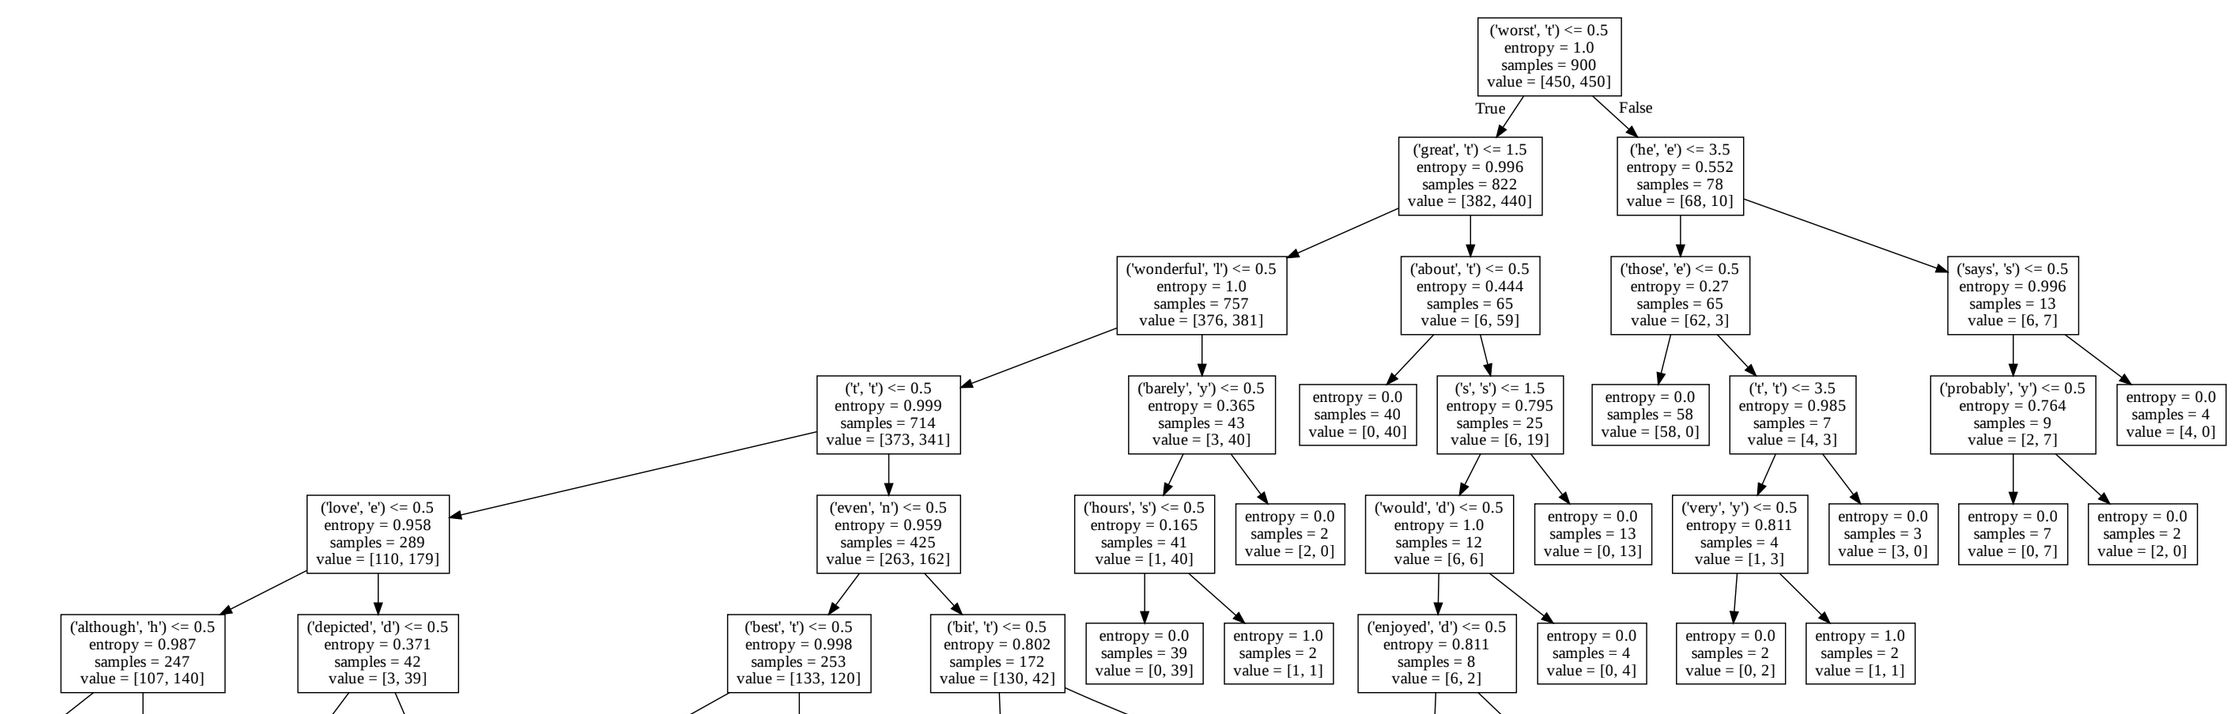

The root node of the tree above tests whether a reivew contains the word 'worst'.  If it does, the word frequency entry for the word is at least 1, hence it is not <= 0.5; therefore, the tweet will follow the right (False) link.

# Code Explanation: Identifying Important Features for Sentiment Classification Using Decision Trees

## Overview
This code implements a Stratified KFold Cross Validation process to:
1. Train and evaluate decision tree models with a specified `max_depth`.
2. Identify and rank important features (words) contributing to sentiment classification.
3. Visualize decision trees for each fold.
4. Save feature importance metrics and decision tree visualizations for further analysis.

---

### Outputs
1. **Performance Metrics**:
   - Precision, recall, and F1-scores for both training and testing data.
   
2. **Feature Importance**:
   - Top features for each fold.
   - Top 40 features based on their average importance across all folds.

3. **Decision Tree Visualizations**:
   - Graphs of decision trees for each fold saved in the `Tree` subfolder.

4. **CSV File**:
   - Feature importance scores stored in a CSV file for further analysis.

---

### Notes
- Ensure all file paths are correctly set for saving visualizations and CSV files.
- The top features identified can provide insights into the sentiment classification process and aid in model interpretation.


In [ ]:
k = 10
skf = StratifiedKFold(n_splits=k, random_state=1, shuffle= True)

Best_max_depth = 4
low_max_depth  = Best_max_depth
high_max_depth = Best_max_depth
training_performance_table = np.empty([high_max_depth + 1, k + 1, 5])
testing_performance_table  = np.empty([high_max_depth + 1, k + 1, 5])

for depth in range(low_max_depth, high_max_depth + 1):

    ### Create a CountVectorizer to map word features of all words in labelled reviews to index of a word frequency matrix.
    #count_vect = CountVectorizer(token_pattern = '((?:([@#]|[0-9]|[a-z]|[A-Z])+))', analyzer= 'word', min_df=2)
    count_vect = CountVectorizer()
    x_all = list(data['review'])
    ### The fit method only creates the column index for the Word Frequency matrix for all words in the review.
    ### Because we did not use fit_transform, no word frequency is filled in yet.
    empty_WF_matrix = count_vect.fit(x_all)

    ### Prepare the feature_importance_array to store all feature importance measures for all k folds
    feature_names = count_vect.get_feature_names_out()
    feature_names_array = np.asarray(feature_names)
    WF_dimension = len(feature_names)
    feature_importance_array = np.empty([k + 1, WF_dimension])
    #Extract only words (not its first character) from feature_names into a list of words only
    words_only_list = list()
    for i in range(0, WF_dimension):
        #words_only_list.append(feature_names_array[i,0])
        words_only_list.append(feature_names_array[i])
    print("Words_only_list:")
    print(words_only_list)

    # Initialize the fold to 1.  The value of fold will increase by 1 in each iteration of the loop below.
    fold = 1
    print("***** Maximum Depth of Decision Tree is ", depth, "******")
    for train_index, test_index in skf.split(data_X, data_Y):
        print("Fold Number:", fold)
        #   print("Training Data Index:", train_index)
        #   print("Testing Data Index:", test_index)
        x_train = list(data.take(train_index)['review'])
        #    print("Training Data:", x_train)
        y_train = list(data.take(train_index)['classification'])
        #    print("Training Data Target Output:", y_train)
        x_test  = list(data.take(test_index)['review'])
        #    print("Testing Data:", x_test)
        y_test  = list(data.take(test_index)['classification'])
        #   print("Testing Data Target Output:", y_test)

        #   We use transform here, rather than fit_transform, because the word frequency columns have been identified
        #   earlier using fit
        X_train_word_vect = count_vect.transform(x_train)
        clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=100, max_depth=depth, min_samples_leaf=2)
        clf.fit(X_train_word_vect, y_train)
        ### Use the model generated to predict for training data
        predicted_training_y = clf.predict(X_train_word_vect)
        train_p  = metrics.precision_score(y_train, predicted_training_y)
        train_r  = metrics.recall_score(y_train, predicted_training_y)
        train_f1 = metrics.f1_score(y_train, predicted_training_y)
        training_performance_table[depth, fold, 0] = depth
        training_performance_table[depth, fold, 1] = train_p
        training_performance_table[depth, fold, 2] = train_r
        training_performance_table[depth, fold, 3] = train_f1
        print("Max depth is ", depth, "Prediction Performance for Training Data f1:", train_f1)

        ### Use the model generated to predict for testing data
        X_test_word_vect = count_vect.transform(x_test)
        predicted_testing_y = clf.predict(X_test_word_vect)

        test_p  = metrics.precision_score(y_test, predicted_testing_y)
        test_r  = metrics.recall_score(y_test, predicted_testing_y)
        test_f1 = metrics.f1_score(y_test, predicted_testing_y)
        testing_performance_table[depth, fold, 0] = depth
        testing_performance_table[depth, fold, 1] = test_p
        testing_performance_table[depth, fold, 2] = test_r
        testing_performance_table[depth, fold, 3] = test_f1
        #   print("Prediction Performance for Testing Data f1:", test_f1)

        ### Obtain feature importance of the model for all words using .feature_importances_
        feature_imp = clf.feature_importances_
        ### We store feature importance of kth fold in fold-i row of feature_importance_array
        ### because the first row of the array has index 0.
        feature_importance_array[fold - 1] = feature_imp
        #   print("Feature_importance_array:")
        #   print(feature_importance_array)

        ### Combine feature importance of this model and feature names to find top 20 important features
        feature_imp_names = zip(feature_imp, words_only_list)
        top_20_features = sorted(feature_imp_names, reverse=True)[:21]
        print("Top 20 important features for fold ", fold)
        for importance, name in top_20_features:
            print(name, importance)

        ### Store a visualization of the decision tree model
        dot_data = tree.export_graphviz(clf, out_file=None, feature_names=count_vect.get_feature_names_out())
        graph = graphviz.Source(dot_data)
        #### Create a string (to be used as the name of the file for storing the deicion tree visualization)
        #### We include fold number in the file name so that we can compare trees with the feature importance of different folds.
        graph_file_path = "/content/drive/My Drive/DS200Labs/Project/Tree/DTV_" + str(depth) + "_Fold_" + str(fold)
        graph.render(graph_file_path)

        fold = fold + 1
        ### End of for loop for k-fold Stratified Cross Validation

    ### Convert Feature Importance Array for all k folds to a Panda DataFrame
    ### with column headings being features (words_only)
    feature_importance_k_fold_DF = pd.DataFrame(data=feature_importance_array, columns=words_only_list)

    ### Calculate the mean of feature importance for all words across all k folds
    feature_imp_k_fold_avg = np.mean(feature_importance_array, axis=0)
    ### Add the average as the last row (row index k) to the feature_importance_k_fold_DF
    ### For example, for a 10 fold feature importance array, row 0 to row 9 stores feature
    ### importance measure for fold 1 to fold 10.  Hence, the average feature importance can
    ### be stored in row 10.
    feature_importance_k_fold_DF.loc[k] = feature_imp_k_fold_avg

    ### Sort the feature_importance_k_fold_DF by row k (i.e., average of feature importance) in DESCENDING order.
    sorted_feature_importance_k_fold_DF = feature_importance_k_fold_DF.sort_values(by=k, axis='columns', ascending=False)
    print("Feature_importance_k_fold_DF sorted")
    print(sorted_feature_importance_k_fold_DF)
    ### Save the sorted feature importance DF as a CSV file
    filename2 = "/content/drive/My Drive/DS200Labs/Project/DTV_" + str(depth) + "_for_" + str(k) + "_Fold" + ".csv"
    sorted_feature_importance_k_fold_DF.to_csv(filename2)

    ### Print top 40 features with highest average feature importance across all folds
    feature_imp_avg_words = zip(feature_imp_k_fold_avg, words_only_list)
    top_40_K_fold_features = sorted(feature_imp_avg_words, reverse=True)[:41]
    print("Top 40 important features across all k folds")
    for importance, word in top_40_K_fold_features:
            print(word, importance)

# End of for loop for max_depth

Words_only_list:
['00', '000', '00001', '001', '007', '00pm', '01', '02', '07', '08', '10', '100', '1000', '10000000000', '1004', '100th', '101', '102', '102nd', '103', '105', '10th', '10x', '11', '111', '115', '116', '118', '119', '11th', '12', '120', '1242', '125', '12a', '12m', '13', '132', '135', '13th', '14', '140', '149', '14th', '15', '150', '1500', '1500s', '15pm', '16', '162', '167', '16mm', '16s', '16th', '17', '171', '17million', '17th', '18', '180', '183', '1837', '1839', '1847', '1850', '1859', '1860', '1861', '1872', '1880', '1894', '1898', '18th', '19', '1900', '1901', '1904', '1906', '1908', '1909', '1915', '1920', '1920ies', '1920s', '1921', '1922', '1923', '1924', '1925', '1927', '1928', '1929', '1930', '1930ies', '1930s', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1940s', '1941', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1950s', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960',